<a href="https://colab.research.google.com/github/armandordorica/velocity_limits/blob/main/Velocity_limits.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!git clone https://github.com/armandordorica/velocity_limits.git

Cloning into 'velocity_limits'...
remote: Enumerating objects: 17, done.
remote: Counting objects: 100% (17/17), done.
remote: Compressing objects: 100% (16/16), done.
remote: Total 17 (delta 2), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (17/17), done.


In [19]:
cd takehome/

/content/velocity_limits/takehome


In finance, it's common for accounts to have so-called "velocity limits". In this task, you'll write a program that accepts or declines attempts to load funds into customers' accounts in real-time.

Each attempt to load funds will come as a single-line JSON payload, structured as follows:

```json
{ "id": "1234", "customer_id": "1234", "load_amount": "$123.45", "time": "2018-01-01T00:00:00Z" }
```

Each customer is subject to three limits:

- A maximum of $\$5,000$ can be loaded per day
- A maximum of $\$20,000$ can be loaded per week
- A maximum of 3 loads can be performed per day, regardless of amount

As such, a user attempting to load $\$3,000$ twice in one day would be declined on the second attempt, as would a user attempting to load $400 four times in a day.

For each load attempt, you should return a JSON response indicating whether the fund load was accepted based on the user's activity, with the structure:

```json
{ "id": "1234", "customer_id": "1234", "accepted": true }
```

You can assume that the input arrives in ascending chronological order and that if a load ID is observed more than once for a particular user, all but the first instance can be ignored. Each day is considered to end at midnight UTC, and weeks start on Monday (i.e. one second after 23:59:59 on Sunday).

Your program should process lines from `input.txt` and return output in the format specified above, either to standard output or a file. Expected output given our input data can be found in `output.txt`.

You're welcome to write your program in a general-purpose language of your choosing.

We value well-structured, self-documenting code with sensible test coverage. Descriptive function and variable names are appreciated, as is isolating your business logic from the rest of your code.


### Importing Source data

In [20]:
import pandas as pd
import matplotlib.pyplot as plt
input_data = pd.read_json('input.txt', lines=True)
input_data.head(), len(input_data)

(      id  customer_id load_amount                  time
 0  15887          528    $3318.47  2000-01-01T00:00:00Z
 1  30081          154    $1413.18  2000-01-01T01:01:22Z
 2  26540          426     $404.56  2000-01-01T02:02:44Z
 3  10694            1     $785.11  2000-01-01T03:04:06Z
 4  15089          205    $2247.28  2000-01-01T04:05:28Z, 1000)

In [21]:
input_data.head()

,id,customer_id,load_amount,time
0,15887,528,$3318.47,2000-01-01T00:00:00Z
1,30081,154,$1413.18,2000-01-01T01:01:22Z
2,26540,426,$404.56,2000-01-01T02:02:44Z
3,10694,1,$785.11,2000-01-01T03:04:06Z
4,15089,205,$2247.28,2000-01-01T04:05:28Z


In [22]:
len(input_data['id']), len(input_data['id'].unique())

(1000, 984)

**"If a load ID is observed more than once for a particular user, all but the first instance can be ignored."** 
* There are 984 unique `id`s

Looking at unique combinations of load `id` and `customer_id`

In [23]:
input_data['unique_id']  = input_data['id'].astype(str) + "_" + input_data['customer_id'].astype(str)

In [24]:
input_data.head()

,id,customer_id,load_amount,time,unique_id
0,15887,528,$3318.47,2000-01-01T00:00:00Z,15887_528
1,30081,154,$1413.18,2000-01-01T01:01:22Z,30081_154
2,26540,426,$404.56,2000-01-01T02:02:44Z,26540_426
3,10694,1,$785.11,2000-01-01T03:04:06Z,10694_1
4,15089,205,$2247.28,2000-01-01T04:05:28Z,15089_205


### 1. Keeping only the first instance for any combination of load id and customer id

In [25]:
grouped_input_data = input_data.groupby(["unique_id"])
input_data = grouped_input_data.first().copy(deep=True)

In [26]:
input_data.head()

,id,customer_id,load_amount,time
unique_id,,,,
10002_35,10002,35,$2385.52,2000-01-20T05:16:22Z
10041_239,10041,239,$5455.00,2000-01-19T00:38:06Z
10041_596,10041,596,$162.67,2000-02-04T22:40:40Z
10047_137,10047,137,$3266.77,2000-01-19T13:55:52Z
10055_460,10055,460,$2671.07,2000-02-08T21:47:46Z


In [27]:
input_data.sort_values(by=['time'], ascending=True, inplace=True)
input_data.reset_index(inplace=True)

In [28]:
input_data.head()

,unique_id,id,customer_id,load_amount,time
0,15887_528,15887,528,$3318.47,2000-01-01T00:00:00Z
1,30081_154,30081,154,$1413.18,2000-01-01T01:01:22Z
2,26540_426,26540,426,$404.56,2000-01-01T02:02:44Z
3,10694_1,10694,1,$785.11,2000-01-01T03:04:06Z
4,15089_205,15089,205,$2247.28,2000-01-01T04:05:28Z


In [29]:
input_data[input_data['unique_id']=='6928_562']

,unique_id,id,customer_id,load_amount,time
108,6928_562,6928,562,$5255.16,2000-01-05T14:27:36Z


* **How many users?**  50
* **How many transactions per user per day? per week? per month?**
* **What is the average transaction amount per user? per day? per week?**

In [30]:
# input_data['load_amount']= input_data.load_amount.replace('[\$,]', '', regex=True).astype(float)


In [31]:
# input_data['load_amount'].mean()

In [32]:
# plt.hist(input_data.load_amount, bins = 50)

In [33]:
# plt.scatter(input_data[input_data['customer_id']==1].time, input_data[input_data['customer_id']==1].customer_id)

In [34]:
# input_data[input_data['customer_id']==1].count(), input_data[input_data['customer_id']==1].min(), input_data[input_data['customer_id']==1].max(), input_data[input_data['customer_id']==1].mean()

In [35]:
customer1_df = input_data[input_data['customer_id']==1]
customer1_df

,unique_id,id,customer_id,load_amount,time
3,10694_1,10694,1,$785.11,2000-01-01T03:04:06Z
18,18705_1,18705,1,$3628.88,2000-01-01T18:24:36Z
66,11456_1,11456,1,$2566.29,2000-01-03T19:30:12Z
165,11114_1,11114,1,$2887.30,2000-01-08T00:45:30Z
171,7485_1,7485,1,$1920.88,2000-01-08T06:53:42Z
223,16907_1,16907,1,$4972.22,2000-01-10T12:04:46Z
229,31045_1,31045,1,$5992.27,2000-01-10T18:12:58Z
276,7806_1,7806,1,$4421.55,2000-01-12T18:17:12Z
496,10262_1,10262,1,$962.12,2000-01-22T03:17:52Z
498,19749_1,19749,1,$4770.96,2000-01-22T05:20:36Z


### Initializing Account Controller

In [36]:
from AccountsController import AccountsController

In [37]:
acct_ctrl1 = AccountsController()
acct_ctrl1.daily_deposit_limit, acct_ctrl1.weekly_deposit_limit, acct_ctrl1.daily_loads

(5000, 20000, 3)

In [38]:
customer1_df['id'] = customer1_df.id.astype(str)
customer1_df['customer_id'] = customer1_df.customer_id.astype(str)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [39]:
customer1_df.iloc[0].to_dict()

{'customer_id': '1',
 'id': '10694',
 'load_amount': '$785.11',
 'time': '2000-01-01T03:04:06Z',
 'unique_id': '10694_1'}

In [40]:
acct_ctrl1.processUserLoad(customer1_df.iloc[0].to_dict())

{'accepted': True, 'customer_id': '1', 'id': '10694'}

In [41]:
acct_ctrl1.processUserLoad(customer1_df.iloc[1].to_dict())

{'accepted': True, 'customer_id': '1', 'id': '18705'}

In [42]:
acct_ctrl1.processUserLoad({'customer_id': '1',
'id': '10694',
'load_amount': '$7785.11',
'time': '2000-01-01T03:04:06Z',
'unique_id': '10694_1'})

{'accepted': False, 'customer_id': '1', 'id': '10694'}

### Helper Functions

In [43]:
#3 rules: 
# 1) A maximum of  $5,000  can be loaded per day
# 2) A maximum of  $20,000  can be loaded per week
# 3) A maximum of 3 loads can be performed per day, regardless of amount

def truth_table(n): 
  return list(itertools.product([0, 1], repeat=n))


num_rules = 3
truth_table_output = truth_table(num_rules)
  
test_cases_df = pd.DataFrame(truth_table_output, columns =['rule1', 'rule2', 'rule3']) 
test_cases_df['test_case_num'] = np.arange(0, len(truth_table(num_rules)))
test_cases_df = test_cases_df[['test_case_num', 'rule1', 'rule2', 'rule3']].copy(deep=True)
test_cases_df

,test_case_num,rule1,rule2,rule3
0,0,0,0,0
1,1,0,0,1
2,2,0,1,0
3,3,0,1,1
4,4,1,0,0
5,5,1,0,1
6,6,1,1,0
7,7,1,1,1


In [90]:
import itertools
import numpy as np
from datetime import datetime, timedelta
import pandas as pd

class Customer: 
  def __init__(self, customer_id, loads=None, daily_deposit_limit=5000, weekly_deposit_limit=20000, daily_loads_limit=3, initial_bal=0, 
               current_daily_deposits=0, current_weekly_deposits=0, current_daily_loads= 0 ):

    self.customer_id = customer_id
    self.loads = []
    self.daily_deposit_limit =  daily_deposit_limit
    self.weekly_deposit_limit =weekly_deposit_limit 
    self.daily_loads_limit = daily_loads_limit 
    self.balance = initial_bal

    self.current_daily_deposits =current_daily_deposits
    self.current_weekly_deposits = current_daily_deposits
    self.current_daily_loads = current_daily_loads


    self.daily_deposits_left = daily_deposit_limit
    self.weekly_deposits_left = weekly_deposit_limit 
    self.daily_loads_left = daily_loads_limit

    self.load_hist = pd.DataFrame({'customer_id':self.customer_id, 'load_id': [], 'load_amt': [], 'load_time': [], 
                                   'load_week_num':[],
                                   'load_day_num':[],
                                   'approved_status':[], 
                                   'rule1':[], 'rule2':[], 'rule3':[]})



  def get_daily_deposits_left(self): 
    self.daily_deposits_left = self.daily_deposit_limit - self.current_daily_deposits
    return self.daily_deposits_left

  def get_weekly_deposits_left(self): 
    self.weekly_deposits_left = self.weekly_deposit_limit - self.current_weekly_deposits
    return self.weekly_deposits_left

  def get_daily_loads_left(self): 
    self.daily_loads_left = self.daily_loads_limit - self.current_daily_loads 
    return self.daily_loads_left

  def update_load_history(self, rule1, rule2, rule3): 
    
    self.load_hist = self.load_hist.append({'customer_id': self.customer_id, \
                                            'load_id': self.loads[-1].load_id, \
                                            'load_amt':self.loads[-1].load_amt, \
                                            'load_time': self.loads[-1].load_time, \
                                            'load_week_num':self.loads[-1].load_week_num,\
                                            'load_day_num':self.loads[-1].load_day_num,\
                                            'approved_status': rule1&rule2&rule3, 
                                            'rule1': rule1, 
                                            'rule2': rule2, 
                                            'rule3': rule3
                                            }, ignore_index=True).copy(deep=True)

    self.load_hist['load_week_num'] = self.load_hist['load_week_num'].astype(int)
    self.load_hist['load_day_num'] = self.load_hist['load_day_num'].astype(int) 

    self.load_hist['approved_status'] = self.load_hist['approved_status'].astype(bool)  
    self.load_hist['rule1'] = self.load_hist['rule1'].astype(bool) 
    self.load_hist['rule2'] = self.load_hist['rule2'].astype(bool) 
    self.load_hist['rule3'] = self.load_hist['rule3'].astype(bool) 


    



  def process_valid_loads(self):
    # keeping only the valid loads (no dupes allowed)
    self.valid_loads = self.load_hist[self.load_hist['approved_status']==True].copy(deep=True)


    df1 = self.valid_loads.set_index('load_time').sort_index().copy(deep=True)

    df2 = pd.DataFrame(df1.groupby('load_week_num')['load_amt'].transform(pd.Series.cumsum)).copy(deep=True)
    df3 = pd.DataFrame(df1.groupby('load_day_num')['load_amt'].transform(pd.Series.cumsum)).copy(deep=True)

    self.valid_loads['cum_weekly_deps'] = list(pd.merge(self.valid_loads, df2, how='left', left_on =['load_time'], right_on=['load_time'])['load_amt_y'])
    self.valid_loads['cum_daily_deps'] = list(pd.merge(self.valid_loads, df3, how='left', left_on =['load_time'], right_on=['load_time'])['load_amt_y'])

    self.valid_loads['weekly_deps_left'] = self.weekly_deposit_limit - self.valid_loads['cum_weekly_deps']
    self.valid_loads['daily_deps_left'] = self.daily_deposit_limit - self.valid_loads['cum_daily_deps']




  def process_load(self, load):
    self.balance += float(load.load_amt)
    self.loads.append(load)

    #3 rules: 
    # 1) A maximum of  $5,000  can be loaded per day
    # 2) A maximum of  $20,000  can be loaded per week
    # 3) A maximum of 3 loads can be performed per day, regardless of amount


    rule1 = False
    rule2 = False
    rule3 = False 

    if self.daily_deposits_left > float(load.load_amt): 
      print("self.daily_deposits_left:{}, float(load.load_amt):{}".format(self.daily_deposits_left, float(load.load_amt)))
      print("Rule 1 approved: Room available in daily loading amount")
      rule1 = True 

    else: 
      print("Rule 1 declined: No room available in daily loading amount")

  
    if self.weekly_deposits_left > float(load.load_amt): 
      print("Rule 2 approved: Room available in weekly loading amount")
      rule2 = True

    else: 
      print("Rule 2 declined: No room available in weekly loading amount")


    if self.daily_loads_left > 1: 
      print("Rule 3 approved: Room available in daily loading count")
      rule3 = True 

    else: 
      print("Rule 3 declined: No room available in daily loading count")


    # only update values if the load id and unique load time are not yet in the history table to avoid duplicates 

    if load.load_id not in list(self.load_hist.load_id) and load.load_time not in list(self.load_hist.load_time): 
      print("Unique values not in history table yet")

      self.update_load_history(rule1, rule2, rule3)
      self.process_valid_loads()


      if rule1 & rule2 & rule3: 
        self.current_daily_deposits+=float(load.load_amt)
        self.current_weekly_deposits+=float(load.load_amt)
        self.current_daily_loads+=1

        self.get_daily_deposits_left()
        self.get_weekly_deposits_left()
        self.get_daily_loads_left()

        self.loads[-1].approved_status = True 
        print("All Rules Passed ... Load Added")

    else: 
      print("Load Rejected")

    return None

  def print_status(self): 
    print("Customer_id:{}".format(self.customer_id))
    print("Current Deposit Balance:{}".format(self.balance))
    print("Current Daily Deposits:{}".format(self.current_daily_deposits))
    print("Current Weekly Deposits:{}".format(self.current_weekly_deposits))
    print("Current Daily Loads:{}".format(self.current_daily_loads))

    print("Daily Deposits Left:{}".format(self.daily_deposits_left))
    print("Weekly Deposits Left:{}".format(self.weekly_deposits_left))
    print("Daily Loads Left:{}".format(self.daily_loads_left))



In [91]:
# import datetime as datetime 
class Load: 
  def __init__(self, load_id, load_amt, load_time):
    self.load_id = load_id
    self.load_amt = float(load_amt[1:])
    self.load_time = load_time 
    self.approved_status = False

    self.datetime_object = datetime.strptime(self.load_time, "%Y-%m-%dT%H:%M:%SZ")
    self.load_week_num = self.datetime_object.year + self.datetime_object.isocalendar()[1]

    import datetime as dt

    self.load_day_num = self.datetime_object.year + (dt.date(self.datetime_object.year, self.datetime_object.month, self.datetime_object.day) - dt.date(self.datetime_object.year,1,1)).days + 1

    # self.day_num = (datetime.date(self.datetime_object.year, self.datetime_object.month, self.datetime_object.day) - datetime.date(year,1,1)).days + 1



    

### Test Case 3 
* `customer_id=1`
* `load =('10694', '$7785.11', '2000-01-01T03:04:06Z')`
* 



In [92]:
def test_case3(): 

  cust1 = Customer(1)
  cust1.process_load(Load('10694', '$7785.11', '2000-01-01T03:04:06Z'))

  response = cust1.load_hist.iloc[0].approved_status
  cust1.print_status()

  print(cust1.load_hist)
  print("Pass:{}".format(response==False))

  assert(response == False)

In [93]:
test_case3()

Rule 1 declined: No room available in daily loading amount
Rule 2 approved: Room available in weekly loading amount
Rule 3 approved: Room available in daily loading count
Unique values not in history table yet
Customer_id:1
Current Deposit Balance:7785.11
Current Daily Deposits:0
Current Weekly Deposits:0
Current Daily Loads:0
Daily Deposits Left:5000
Weekly Deposits Left:20000
Daily Loads Left:3
   customer_id load_id  load_amt  ...  rule1  rule2  rule3
0            1   10694   7785.11  ...  False   True   True

[1 rows x 10 columns]
Pass:True


In [94]:
customer_id = input_data.iloc[[0]].customer_id.iloc[0]
cust = Customer(customer_id)

In [95]:
cust.load_hist

,customer_id,load_id,load_amt,load_time,load_week_num,load_day_num,approved_status,rule1,rule2,rule3


In [96]:
load_id =input_data.iloc[[0]].id.iloc[0]
load_amount = input_data.iloc[[0]].load_amount.iloc[0]
load_time = input_data.iloc[[0]].time.iloc[0]

cust.process_load(Load(load_id, load_amount, load_time))
cust.load_hist

self.daily_deposits_left:5000, float(load.load_amt):3318.47
Rule 1 approved: Room available in daily loading amount
Rule 2 approved: Room available in weekly loading amount
Rule 3 approved: Room available in daily loading count
Unique values not in history table yet
All Rules Passed ... Load Added


,customer_id,load_id,load_amt,load_time,load_week_num,load_day_num,approved_status,rule1,rule2,rule3
0,528,15887.0,3318.47,2000-01-01T00:00:00Z,2052,2001,True,True,True,True


In [97]:
load_id = '1834'
load_amount = input_data.iloc[[0]].load_amount.iloc[0]
load_time = '2000-02-01T00:00:00Z'

cust.process_load(Load(load_id, load_amount, load_time))
cust.load_hist

Rule 1 declined: No room available in daily loading amount
Rule 2 approved: Room available in weekly loading amount
Rule 3 approved: Room available in daily loading count
Unique values not in history table yet


,customer_id,load_id,load_amt,load_time,load_week_num,load_day_num,approved_status,rule1,rule2,rule3
0,528,15887,3318.47,2000-01-01T00:00:00Z,2052,2001,True,True,True,True
1,528,1834,3318.47,2000-02-01T00:00:00Z,2005,2032,False,False,True,True


In [98]:
cust.valid_loads

,customer_id,load_id,load_amt,load_time,load_week_num,load_day_num,approved_status,rule1,rule2,rule3,cum_weekly_deps,cum_daily_deps,weekly_deps_left,daily_deps_left
0,528,15887,3318.47,2000-01-01T00:00:00Z,2052,2001,True,True,True,True,3318.47,3318.47,16681.53,1681.53


In [99]:
load_id = '1835'
load_amount = '$5'
load_time = '2000-02-02T00:00:00Z'

cust.process_load(Load(load_id, load_amount, load_time))
cust.load_hist

self.daily_deposits_left:1681.5300000000002, float(load.load_amt):5.0
Rule 1 approved: Room available in daily loading amount
Rule 2 approved: Room available in weekly loading amount
Rule 3 approved: Room available in daily loading count
Unique values not in history table yet
All Rules Passed ... Load Added


,customer_id,load_id,load_amt,load_time,load_week_num,load_day_num,approved_status,rule1,rule2,rule3
0,528,15887,3318.47,2000-01-01T00:00:00Z,2052,2001,True,True,True,True
1,528,1834,3318.47,2000-02-01T00:00:00Z,2005,2032,False,False,True,True
2,528,1835,5.00,2000-02-02T00:00:00Z,2005,2033,True,True,True,True


In [100]:
cust.valid_loads

,customer_id,load_id,load_amt,load_time,load_week_num,load_day_num,approved_status,rule1,rule2,rule3,cum_weekly_deps,cum_daily_deps,weekly_deps_left,daily_deps_left
0,528,15887,3318.47,2000-01-01T00:00:00Z,2052,2001,True,True,True,True,3318.47,3318.47,16681.53,1681.53
2,528,1835,5.00,2000-02-02T00:00:00Z,2005,2033,True,True,True,True,5.00,5.00,19995.00,4995.00


In [101]:
load_id = '1836'
load_amount = '$80'
load_time = '2000-02-03T00:00:00Z'

cust.process_load(Load(load_id, load_amount, load_time))
cust.load_hist

self.daily_deposits_left:1676.5300000000002, float(load.load_amt):80.0
Rule 1 approved: Room available in daily loading amount
Rule 2 approved: Room available in weekly loading amount
Rule 3 declined: No room available in daily loading count
Unique values not in history table yet


,customer_id,load_id,load_amt,load_time,load_week_num,load_day_num,approved_status,rule1,rule2,rule3
0,528,15887,3318.47,2000-01-01T00:00:00Z,2052,2001,True,True,True,True
1,528,1834,3318.47,2000-02-01T00:00:00Z,2005,2032,False,False,True,True
2,528,1835,5.00,2000-02-02T00:00:00Z,2005,2033,True,True,True,True
3,528,1836,80.00,2000-02-03T00:00:00Z,2005,2034,False,True,True,False


In [102]:
load_id = '1837'
load_amount = '$100'

load_time = '2000-02-04T00:00:00Z'
cust.process_load(Load(load_id, load_amount, load_time))
cust.load_hist

self.daily_deposits_left:1676.5300000000002, float(load.load_amt):100.0
Rule 1 approved: Room available in daily loading amount
Rule 2 approved: Room available in weekly loading amount
Rule 3 declined: No room available in daily loading count
Unique values not in history table yet


,customer_id,load_id,load_amt,load_time,load_week_num,load_day_num,approved_status,rule1,rule2,rule3
0,528,15887,3318.47,2000-01-01T00:00:00Z,2052,2001,True,True,True,True
1,528,1834,3318.47,2000-02-01T00:00:00Z,2005,2032,False,False,True,True
2,528,1835,5.00,2000-02-02T00:00:00Z,2005,2033,True,True,True,True
3,528,1836,80.00,2000-02-03T00:00:00Z,2005,2034,False,True,True,False
4,528,1837,100.00,2000-02-04T00:00:00Z,2005,2035,False,True,True,False


In [103]:
cust.valid_loads

,customer_id,load_id,load_amt,load_time,load_week_num,load_day_num,approved_status,rule1,rule2,rule3,cum_weekly_deps,cum_daily_deps,weekly_deps_left,daily_deps_left
0,528,15887,3318.47,2000-01-01T00:00:00Z,2052,2001,True,True,True,True,3318.47,3318.47,16681.53,1681.53
2,528,1835,5.00,2000-02-02T00:00:00Z,2005,2033,True,True,True,True,5.00,5.00,19995.00,4995.00


In [82]:
cust.valid_loads.sort_values(by=['load_time'], ascending = False)

,customer_id,load_id,load_amt,load_time,load_week_num,load_day_num,approved_status,rule1,rule2,rule3,cum_weekly_deps,weekly_deps_left
2,528,1835,5.00,2000-02-02T00:00:00Z,2005,2033,True,True,True,True,5.00,19995.00
0,528,15887,3318.47,2000-01-01T00:00:00Z,2052,2001,True,True,True,True,3318.47,16681.53


In [87]:
cust.valid_loads = cust.load_hist[cust.load_hist['approved_status']==True].copy(deep=True)

df1 = cust.valid_loads.set_index('load_time').sort_index().copy(deep=True)


df2 = pd.DataFrame(df1.groupby('load_week_num')['load_amt'].transform(pd.Series.cumsum)).copy(deep=True)

df3 = pd.DataFrame(df1.groupby('load_day_num')['load_amt'].transform(pd.Series.cumsum)).copy(deep=True)



cust.valid_loads['cum_weekly_deps'] = list(pd.merge(cust.valid_loads, df2, how='left', left_on =['load_time'], right_on=['load_time'])['load_amt_y'])


cust.valid_loads['cum_daily_deps'] = list(pd.merge(cust.valid_loads, df3, how='left', left_on =['load_time'], right_on=['load_time'])['load_amt_y'])


cust.valid_loads['weekly_deps_left'] = cust.weekly_deposit_limit - cust.valid_loads['cum_weekly_deps']

cust.valid_loads['daily_deps_left'] = cust.daily_deposit_limit - cust.valid_loads['cum_daily_deps']




In [89]:
cust.valid_loads

,customer_id,load_id,load_amt,load_time,load_week_num,load_day_num,approved_status,rule1,rule2,rule3,cum_weekly_deps,cum_daily_deps,weekly_deps_left,daily_deps_left
0,528,15887,3318.47,2000-01-01T00:00:00Z,2052,2001,True,True,True,True,3318.47,3318.47,16681.53,1681.53
2,528,1835,5.00,2000-02-02T00:00:00Z,2005,2033,True,True,True,True,5.00,5.00,19995.00,4995.00


In [ ]:
import pytest

In [ ]:
def inc(x):
    return x + 1


def test_answer():
    assert inc(3) == 5

In [ ]:
!pytest

============================= test session starts ==============================
platform linux2 -- Python 2.7.17, pytest-3.6.4, py-1.8.0, pluggy-0.7.1
rootdir: /content/velocity_limits/takehome, inifile:
collected 0 items                                                              

========================= no tests ran in 0.00 seconds =========================


In [ ]:
output_data = pd.read_json("output.txt", lines=True)
output_data.head(), len(output_data)

(      id  customer_id  accepted
 0  15887          528      True
 1  30081          154      True
 2  26540          426      True
 3  10694            1      True
 4  15089          205      True, 999)

In [ ]:
output_amar_data = pd.read_json("output_amar.txt", lines=True)
output_amar_data.head(), len(output_amar_data)

(   accepted  customer_id     id
 0      True          528  15887
 1      True          154  30081
 2      True          426  26540
 3      True            1  10694
 4      True          205  15089, 999)

In [ ]:
common_df= pd.merge(input_data, output_data, how='inner' ,left_on=['id', 'customer_id'], right_on=['id', 'customer_id'])

In [ ]:
common_df.head()

,id,customer_id,load_amount,time,accepted
0,15887,528,$3318.47,2000-01-01T00:00:00Z,True
1,30081,154,$1413.18,2000-01-01T01:01:22Z,True
2,26540,426,$404.56,2000-01-01T02:02:44Z,True
3,10694,1,$785.11,2000-01-01T03:04:06Z,True
4,15089,205,$2247.28,2000-01-01T04:05:28Z,True


In [ ]:
id_counts = common_df.groupby(['id']).count()

In [ ]:
id_counts[id_counts['customer_id']>1]

,customer_id,load_amount,time,accepted
id,,,,
1827,2,2,2,2
5330,2,2,2,2
5472,2,2,2,2
6591,2,2,2,2
6928,2,2,2,2
7185,2,2,2,2
7518,2,2,2,2
10041,2,2,2,2
13812,2,2,2,2


In [ ]:
common_df[common_df['id']==1827]

,id,customer_id,load_amount,time,accepted
345,1827,698,$971.86,2000-01-15T15:50:08Z,True
701,1827,766,$4522.88,2000-01-30T20:58:02Z,False


In [ ]:
output_amar_data[output_amar_data['id']==1827]

,accepted,customer_id,id
344,True,698,1827
700,False,766,1827


Text(0, 0.5, 'Load Amount')

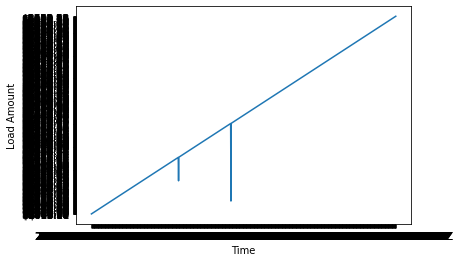

In [ ]:
import matplotlib.pyplot as plt
plt.plot(input_data['time'], input_data['load_amount'])
plt.xlabel("Time")
plt.ylabel("Load Amount")

There are 984 unique load ids, 50 unique customer_ids. 


In [ ]:
num_unique_ids = len(input_data['id'].unique())
num_unique_customer_ids = len(input_data['customer_id'].unique())
num_unique_ids, num_unique_customer_ids 

(984, 50)

(array([100., 100., 100., 100., 100., 100., 100., 100., 100., 100.]),
 array([  0. ,  99.9, 199.8, 299.7, 399.6, 499.5, 599.4, 699.3, 799.2,
        899.1, 999. ]),
 <a list of 10 Patch objects>)

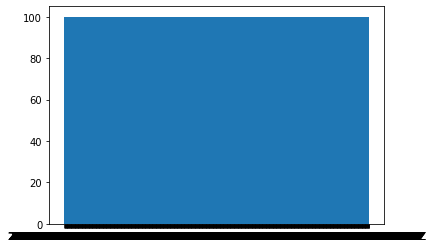

In [ ]:
plt.hist(input_data['time'])

(5000, 20000, 3)

### As such, a user attempting to load $3,000 twice in one day would be declined on the second attempt

In [ ]:
acct_ctrl1.processUserLoad(input_data_list[0])

{'accepted': True, 'customer_id': '528', 'id': '15887'}

In [ ]:
acct_ctrl1.processUserLoad(input_data_list[0])

{'accepted': False, 'customer_id': '528', 'id': '15887'}

In [ ]:
acct_ctrl1

 ### A user attempting to load $400 four times in a day should be declined 

In [ ]:
acct_ctrl2 = AccountsController()

In [ ]:
# input_data_list

In [ ]:
loads = {'customer_id': '154',
  'id': '404',
  'load_amount': '$400.00',
  'time': '2000-01-22T20:41:06Z'}

acct_ctrl2.processUserLoad(load)

{'accepted': True, 'customer_id': '154', 'id': '404'}

In [ ]:
input_file = open('input.txt', 'r')
json_lines = input_file.readlines()

In [ ]:
# json_lines

In [ ]:
import json

load_id_json = {}

accounts_controller= AccountsController()

#Create a write to file output_amar.txt
with open('output_amar2.txt', 'w') as outfile:
    for line in json_lines:
        customer_json = json.loads(line)
        customer_id = customer_json['customer_id']
        load_id = customer_json['id']
        if customer_id not in load_id_json:
            load_id_json[customer_id] = []
        #Do a check if load_id already exists for that specific customer
        if load_id in load_id_json[customer_id]:         
            continue
        else:
            json.dump(accounts_controller.processUserLoad(customer_json), outfile)
            outfile.write('\n')
            load_id_json[customer_id].append(load_id)

In [ ]:
ls

AccountsController.py  output_accounts.py  output_amar.txt  __pycache__/
input.txt              output_amar2.txt    output.txt       README.md


In [ ]:
df[df['customer_id']==528]

,id,customer_id,load_amount,time


In [ ]:
len(df)

1000

In [ ]:
ls

AccountsController.py  output_accounts.py  output_amar.txt  __pycache__/
input.txt              output_amar2.txt    output.txt       README.md


,id,customer_id,load_amount,time
0,15887,528,$3318.47,2000-01-01T00:00:00Z
1,30081,154,$1413.18,2000-01-01T01:01:22Z
2,26540,426,$404.56,2000-01-01T02:02:44Z
3,10694,1,$785.11,2000-01-01T03:04:06Z
4,15089,205,$2247.28,2000-01-01T04:05:28Z
...,...,...,...,...
995,6082,460,$4773.93,2000-02-12T09:39:50Z
996,17742,477,$3490.83,2000-02-12T10:41:12Z
997,31634,494,$5159.54,2000-02-12T11:42:34Z
998,1897,409,$3412.50,2000-02-12T12:43:56Z
